# Bayesian Data Analysis
## PPCA with priors on weights


In [1]:
import numpy as np
import pystan
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import linalg
import copy
# edit default plot settings (colours from colorbrewer2.org)
plt.rc('figure', figsize=(8,6))
plt.rc('font', size=14)
plt.rc('lines', color='#377eb8', linewidth=2)
plt.rc('axes', color_cycle=('#377eb8','#e41a1c','#4daf4a',
                            '#984ea3','#ff7f00','#ffff33'))

/Users/nbip/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Now we introduce an independent Gaussian prior on each column of the weights. Each gaussian has a precision hyperparameter $\alpha_i$ so that

\begin{equation}
p(W|\alpha) = \prod_{i=1}^M \left( \frac{\alpha_i}{2\pi} \right)^{D/2} \exp{-\frac{1}{2}\alpha_i w_i^Tw_i}
\end{equation}

So now we are trying to infer 

$$p(W,\alpha | y)$$

where we can marginalize for $W$ or $\alpha$ and the $\alpha$'s will tell us something about the sparsity of the problem

In [2]:
class createData:
    'documentation'
    
    def __init__(self,d,dl,n,mu,sigma2):
        # sample latent variable Z
        self.Z = np.random.multivariate_normal(np.zeros(dl),np.identity(dl),n).T  # dl x n    

        # create additive noise
        noise = np.random.multivariate_normal(np.zeros(d),sigma2*np.identity(d),n).T  # d x n
        
        # create orthogonal signal directions
        self.W = linalg.orth(np.random.random((d,dl)))  # d x dl

        # data-space data
        self.Y = np.dot(self.W,self.Z) + noise;
        
        
    def removeData(self,m):
        # copy of original data
        y_miss = copy.copy(self.Y)
        # indicator matrix, 1 for present, 0 for missing
        S = np.ones((d,n))        
        
        # matrix of uniformly distributed random numbers
        r = np.random.uniform(0,1,(d,n))
        
        # boolean of those lower than specified missing rate
        bol = r<m
        
        # set entries to nan as specified by bol
        y_miss[bol] = np.nan
        S[bol] = 0
        
        return dict(y_miss=y_miss,S=S)

In [3]:
d=5
dl=1      # number of true latent variable dimensions
k=4       # number of latent variable dimensions in the model
n=500
mu=np.zeros(d)
sigma2=0.05

datObj = createData(d,dl,n,mu,sigma2)
# extract quantities
W = datObj.W
Z = datObj.Z
Y = datObj.Y

## Stan model with priors on weights

In [4]:
# =============== PPCA model with priors on weights ===================
ppca_prior_code = """
data {
  int<lower=1> N;             // num datapoints
  int<lower=1> D;              // num dimension
  int<lower=1> K;              // num basis
  real<lower=0> ones;
  real y[D,N];
}
transformed data {
  matrix[K,K] Sigma;
  vector<lower=0>[K] diag_elem;
  vector<lower=0>[K] zr_vec;
  for (k in 1:K) zr_vec[k] <- 0;
  for (k in 1:K) diag_elem[k] <- ones;
  Sigma <- diag_matrix(diag_elem);
}
parameters {
  matrix[D,K] A;            // basis
  vector[K] x[N];           // coefficients
  real<lower=0> sigma;      // noise variance
  vector<lower=0>[K] alpha; // prior on weights
}
model {  
  
  for (i in 1:N)
      x[i] ~ multi_normal(zr_vec, Sigma);
      
  for (d in 1:D)
    for (k in 1:K)
      A[d,k] ~ normal(0, alpha[k]);
  
  for (i in 1:N)
    for (d in 1:D)
      //y[d,i] ~ normal(dot_product(row(A, d), x[i]), sigma);
      increment_log_prob(normal_log(y[d,i], dot_product(row(A, d), x[i]), sigma));
}
generated quantities {
    vector[N] log_lik;
    for (n in 1:N)
       for (d in 1:D)
        log_lik[n] <- normal_log(y[d,n], dot_product(row(A, d), x[n]), sigma);
}
"""
data = dict(N=n, D=d, K=k, ones=1, 
            y=Y)
fit = pystan.stan(model_code=ppca_prior_code, data=data)
print(fit)
samples = fit.extract(permuted=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b9a1b20597fd32487b29e390b6079fd NOW.


Inference for Stan model: anon_model_8b9a1b20597fd32487b29e390b6079fd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
A[0,0]        -0.14    0.17   0.25  -0.59  -0.39-8.4e-3 6.5e-3   0.06      2   8.55
A[1,0]        -0.08     0.1   0.15  -0.36  -0.23-7.8e-3 7.6e-3   0.07      2   5.78
A[2,0]        -0.15    0.17   0.24  -0.59  -0.39  -0.01 3.9e-3   0.05      2   7.76
A[3,0]        -0.05    0.06   0.09  -0.21  -0.15  -0.01 5.3e-3   0.05      2   3.36
A[4,0]         -0.1    0.12   0.17  -0.42  -0.27-7.6e-3 5.4e-3   0.04      2   7.79
A[0,1]        -0.14    0.18   0.25  -0.59  -0.32-3.4e-3 9.0e-3   0.09      2   8.17
A[1,1]        -0.08    0.11   0.15  -0.36  -0.21-3.4e-3 8.9e-3   0.07      2   6.31
A[2,1]        -0.14    0.17   0.24  -0.59  -0.34-7.3e-3 5.8e-3   0.08      2   7.83
A[3,1]        -0.05    0.06   0.09  -0.21  -0.14-8.5e-3

In [5]:
alpha = samples['alpha']
alpha.shape
np.mean(alpha,axis=0)

array([ 0.15668971,  0.17820139,  0.30714978,  0.03670722])

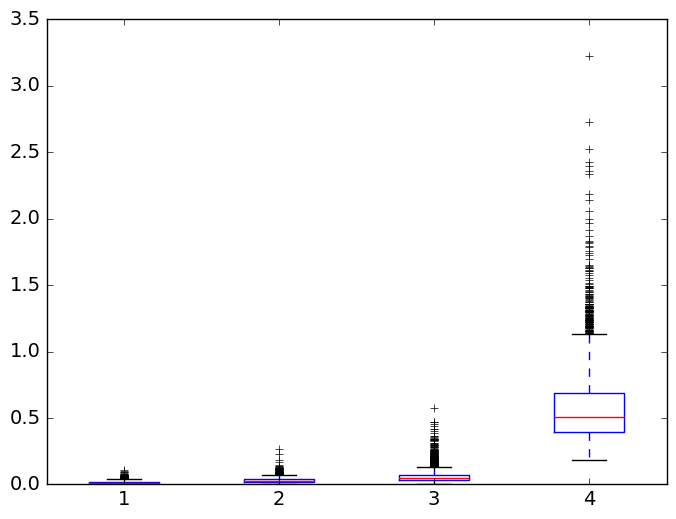

In [6]:
ix = np.argsort(alpha)
alpha_sorted = np.sort(alpha)
plt.boxplot(alpha_sorted);

In [7]:
#binwidth = 0.01

#for i in range(0,k):
#    plt.hist(alpha[:,i],bins=np.arange(0.0, 1.0+binwidth, binwidth))
#    axes = plt.gca()
#    axes.set_xlim([0,2])
#    plt.show()

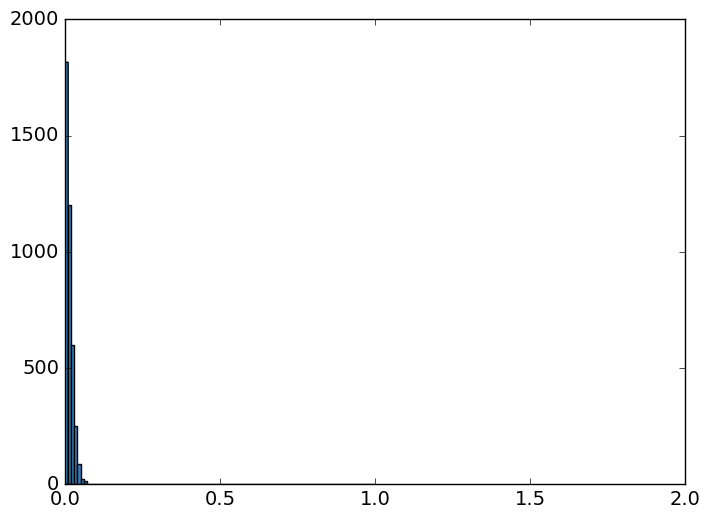

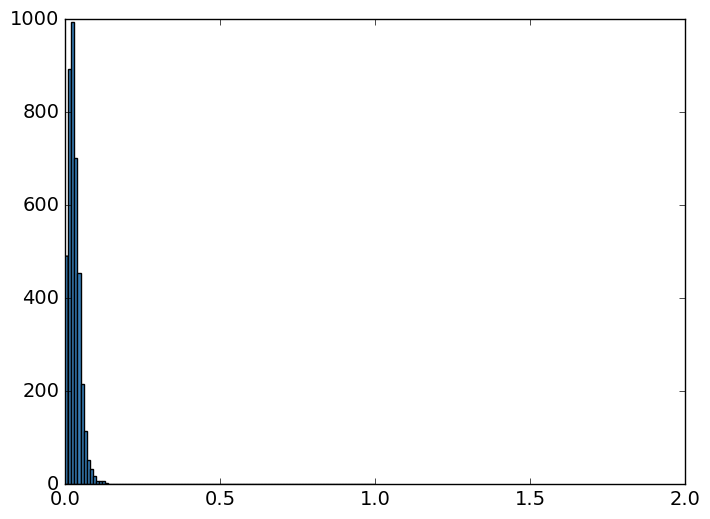

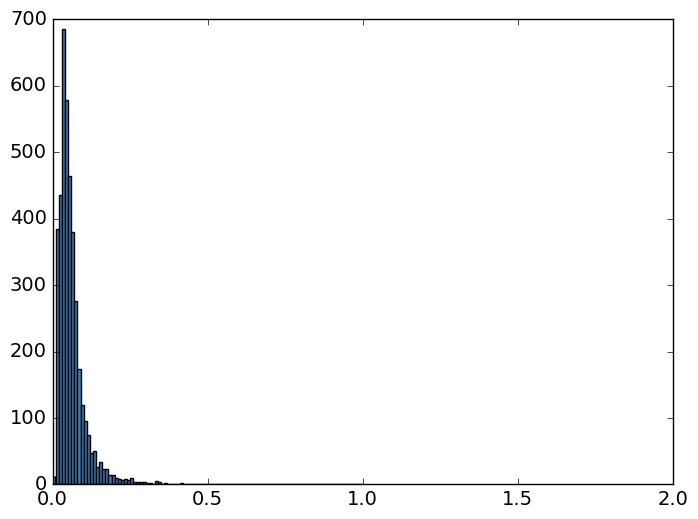

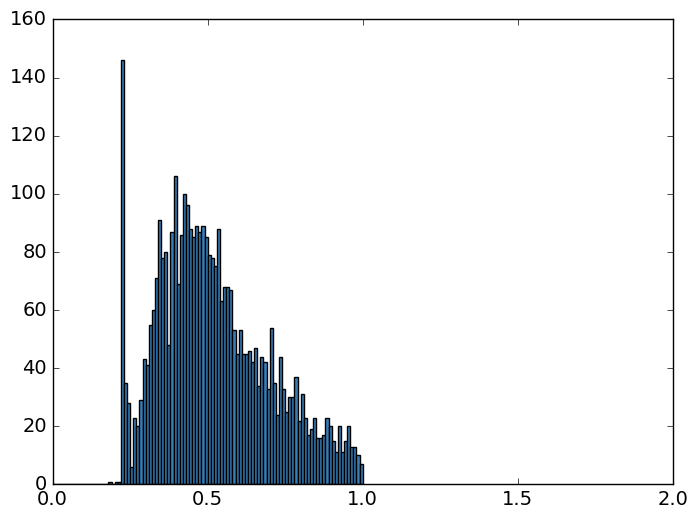

In [8]:
binwidth = 0.01

for i in range(0,k):
    plt.hist(alpha_sorted[:,i],bins=np.arange(0.0, 1.0+binwidth, binwidth))
    axes = plt.gca()
    axes.set_xlim([0,2])
    plt.show()

## Transformation matrix (principal components)

In [9]:
A = samples['A']
A.shape

(4000, 5, 4)

In [10]:
# the maximum alpha value and index
ma = np.max(alpha[0,:])
ix = np.argmax(alpha[0,:])
ix

0

In [11]:
# the correspnding weight vector
W_est = A[0,:,ix]
W_est

array([-0.5284927 , -0.32882551, -0.52213774, -0.171984  , -0.37153168])

In [12]:
W

array([[ 0.57845642],
       [ 0.34459379],
       [ 0.59065001],
       [ 0.20140385],
       [ 0.39650012]])

<Container object of 5 artists>

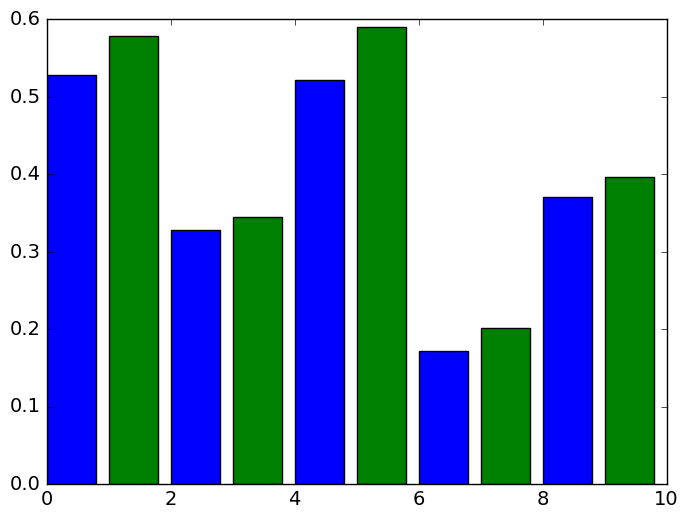

In [13]:
plt.bar(range(0,2*len(W_est),2),abs(W_est))
plt.bar(range(1,2*len(W)+1,2),W,color='g')

## Noise variance

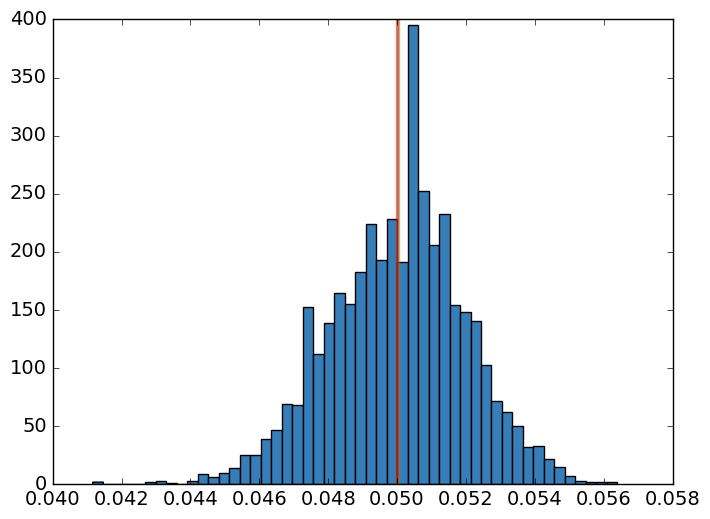

In [14]:
tmp = samples['sigma']
sigma = [x*x for x in tmp];
s2 = np.mean(sigma)
plt.hist(sigma,50)
plt.axvline(s2, color='#4daf4a', linewidth=2.5, alpha=0.5)
plt.axvline(sigma2, color='#ff0000', linewidth=2.5, alpha=0.5);

## Horseshoe prior

We now change the prior from the independent Gaussians with hyperparameter $\alpha$ to

$$
w_i | \lambda_i, \tau \sim N(0,\lambda_i^2\tau^2 I)\\
\lambda_i \sim C^+(0,1)
$$

There is a global shrinkage parameter $\tau$ that shrinks all the parameters towards zero and then there is a local shrinkage parameter $\lambda_i$, individual to each weight column, which allows some weights $w_i$ to escape this shrinkage.
It seems that also the global shrinkage parameter could be drawn from a half-cauchy distribution (as in for example "Hierarchical Bayesian Survival Analysis and Projective Covariate Selection in Cardiovascular Event Risk Prediction")

$$
\tau \sim C^+(0,1)
$$

One source for implementing this
https://www.ariddell.org/horseshoe-prior-with-stan.html


In [15]:
# =============== PPCA model with priors on weights ===================
ppca_prior_code = """
data {
  int<lower=1> N;             // num datapoints
  int<lower=1> D;              // num dimension
  int<lower=1> K;              // num basis
  real<lower=0> ones;
  real y[D,N];
}
transformed data {
  matrix[K,K] Sigma;
  vector<lower=0>[K] diag_elem;
  vector<lower=0>[K] zr_vec;
  for (k in 1:K) zr_vec[k] <- 0;
  for (k in 1:K) diag_elem[k] <- ones;
  Sigma <- diag_matrix(diag_elem);
}
parameters {
  matrix[D,K] A;             // basis
  vector[K] x[N];            // coefficients
  real<lower=0> sigma;       // noise variance
  vector<lower=0>[K] lambda; // the local prior on the weights
  real<lower=0> tau;         // the global prior on the weights        
}
model {  
  
  lambda ~ cauchy(0,1);
  tau ~ cauchy(0,1);
  
  for (i in 1:N)
      x[i] ~ multi_normal(zr_vec, Sigma);
      
  for (d in 1:D)
    for (k in 1:K)
      A[d,k] ~ normal(0, lambda[k]*lambda[k]*tau*tau);
  
  for (i in 1:N)
    for (d in 1:D)
      //y[d,i] ~ normal(dot_product(row(A, d), x[i]), sigma);
      increment_log_prob(normal_log(y[d,i], dot_product(row(A, d), x[i]), sigma));
}
generated quantities {
    vector[N] log_lik;
    for (n in 1:N)
       for (d in 1:D)
        log_lik[n] <- normal_log(y[d,n], dot_product(row(A, d), x[n]), sigma);
}
"""
data = dict(N=n, D=d, K=k, ones=1, 
            y=Y)
fit = pystan.stan(model_code=ppca_prior_code, data=data)
print(fit)
samples = fit.extract(permuted=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_26055bc017595d46b1403d50d9da5456 NOW.


Inference for Stan model: anon_model_26055bc017595d46b1403d50d9da5456.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
A[0,0]         0.14    0.17   0.25  -0.04-1.8e-3 2.2e-3   0.32   0.59      2  14.99
A[1,0]         0.08     0.1   0.15  -0.03-2.0e-3 1.7e-3    0.2   0.36      2   9.84
A[2,0]         0.14    0.17   0.24  -0.03-1.4e-3 2.4e-3   0.32   0.58      2  14.28
A[3,0]         0.05    0.06   0.09  -0.04-2.8e-3 1.5e-3   0.12   0.21      2   5.41
A[4,0]          0.1    0.12   0.17  -0.03-1.8e-3 1.7e-3   0.22   0.42      2  12.63
A[0,1]       2.0e-4  8.6e-4   0.02  -0.04-5.8e-3 1.8e-4 6.0e-3   0.05    501   1.01
A[1,1]      -9.9e-4  8.0e-4   0.02  -0.04-6.1e-3-9.1e-5 5.0e-3   0.04    522    1.0
A[2,1]       3.8e-4  1.4e-3   0.02  -0.05-5.3e-3-1.0e-4 6.2e-3   0.05    224   1.01
A[3,1]       6.9e-4  1.1e-3   0.02  -0.05-5.3e-3 5.8e-5

In [16]:
tau = samples['tau']
lamb = samples['lambda']
A = samples['A']

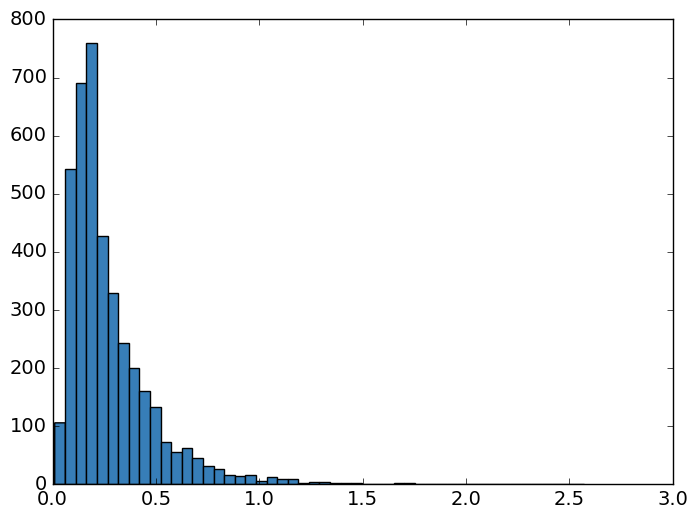

In [17]:
plt.hist(tau,50);

In [18]:
#binwidth = 0.01

#for i in range(0,k):
#    plt.hist(tau*lamb[:,i],bins=np.arange(0.0, 1.0+binwidth, binwidth))
#    axes = plt.gca()
#    axes.set_xlim([0,2])
#    plt.show()

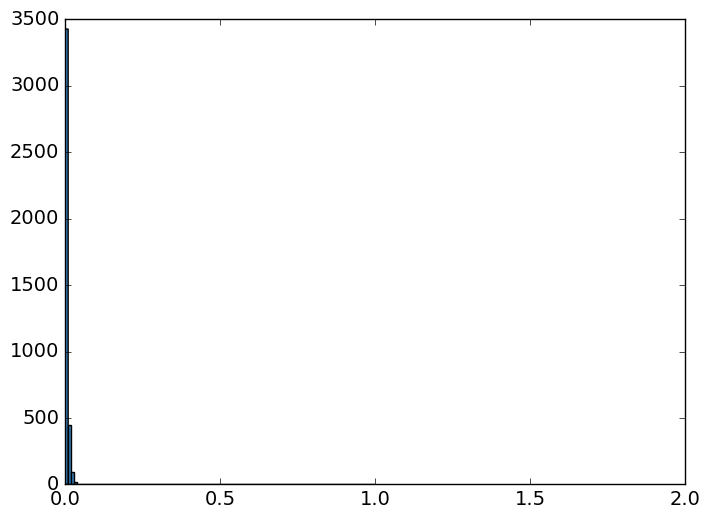

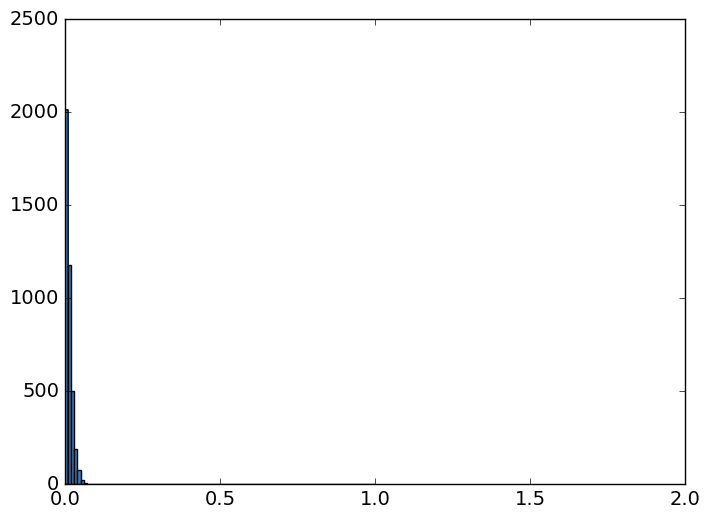

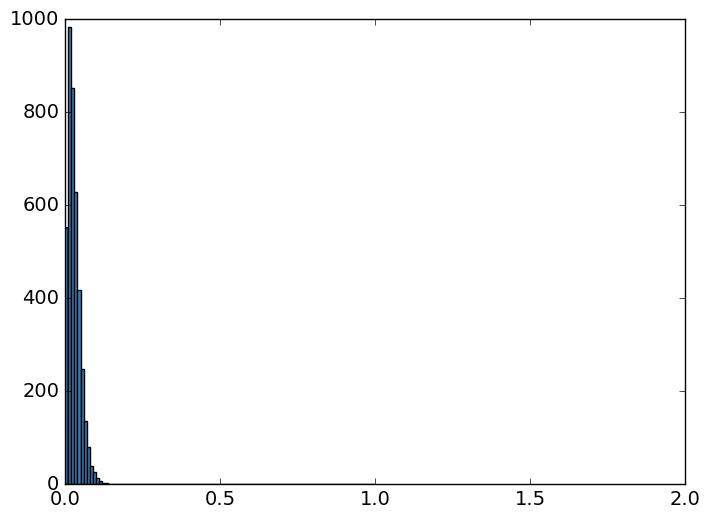

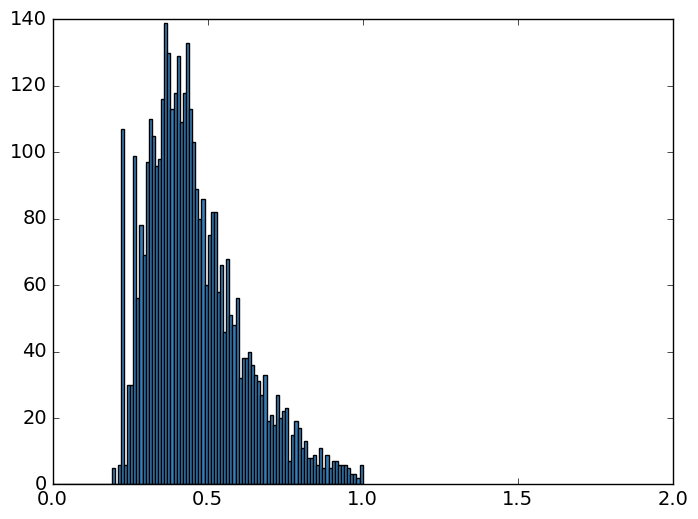

In [19]:
binwidth = 0.01
ix = np.argsort(lamb)
lambda_sorted = np.sort(lamb)
for i in range(0,k):
    plt.hist(tau*tau*lambda_sorted[:,i]*lambda_sorted[:,i],bins=np.arange(0.0, 1.0+binwidth, binwidth))
    axes = plt.gca()
    axes.set_xlim([0,2])
    plt.show()

# Sort the weights according to their shrinkage

In [20]:
shrinkage = np.zeros(lamb.shape)

for i in range(0,len(lamb)):
    shrinkage[i,:] = tau[i]*tau[i]*lamb[i,:]*lamb[i,:]

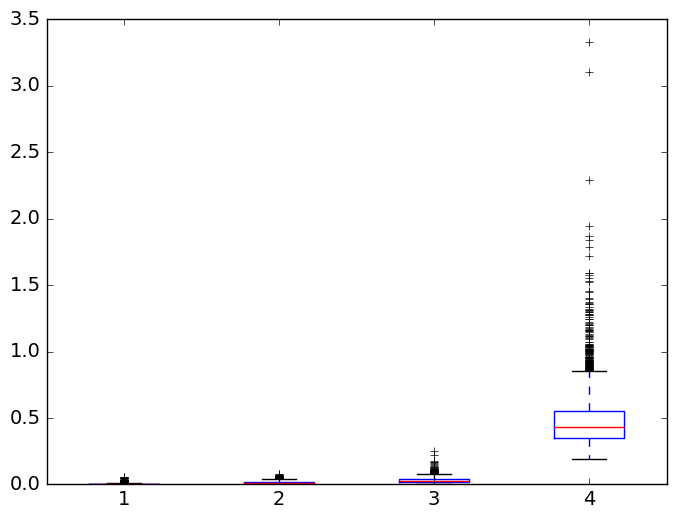

In [21]:
ix = np.argsort(shrinkage)
shrinkage_sorted = np.sort(shrinkage)
plt.boxplot(shrinkage_sorted);

# sort weights according to shrinkage and take the mean over samples

In [22]:
B = np.zeros(A.shape)
for i in range(0,len(A)):
    B[i,:,:] = A[i,:,ix[i,:]].T

In [23]:
W_est = np.mean(abs(B[:,:,3]),axis=0)

In [24]:
W

array([[ 0.57845642],
       [ 0.34459379],
       [ 0.59065001],
       [ 0.20140385],
       [ 0.39650012]])

In [25]:
W_est

array([ 0.56238304,  0.33575717,  0.557393  ,  0.19538936,  0.39520996])

<Container object of 5 artists>

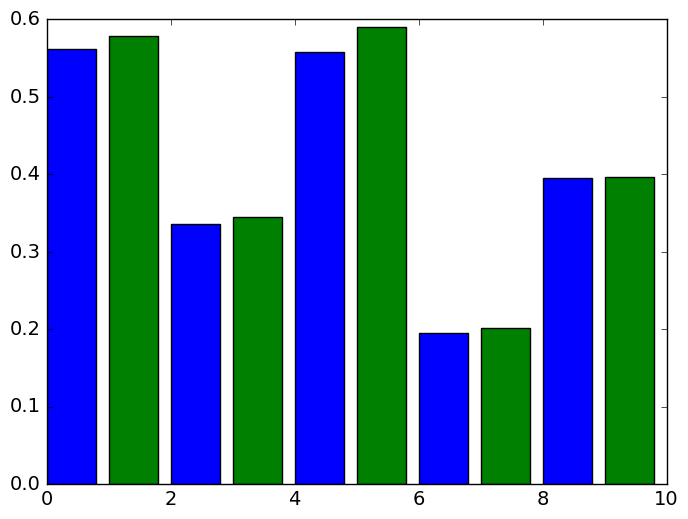

In [26]:
plt.bar(range(0,2*len(W_est),2),abs(W_est))
plt.bar(range(1,2*len(W)+1,2),W,color='g')

## how does a weight with more shrinkage look?

In [27]:
W_another = np.mean(abs(B[:,:,2]),axis=0)
W_another

array([ 0.01990862,  0.01816537,  0.01977196,  0.02177589,  0.01594735])

<Container object of 5 artists>

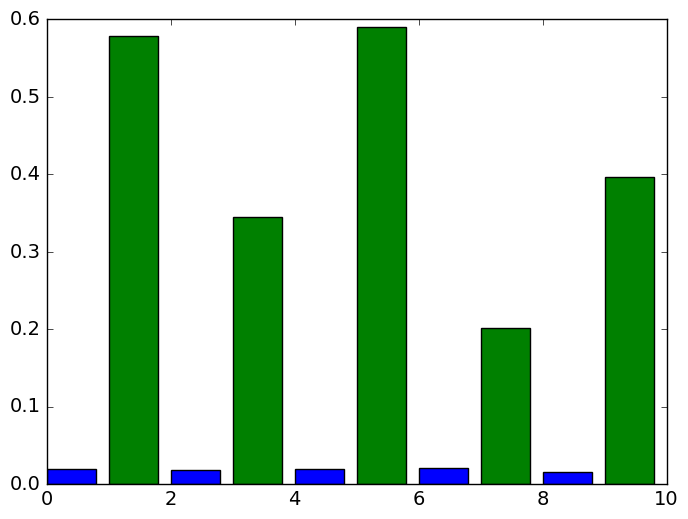

In [28]:
plt.bar(range(0,2*len(W_another),2),abs(W_another))
plt.bar(range(1,2*len(W)+1,2),W,color='g')